# **Impact Assessment**

### Import processing and prepping libraries

In [1]:
#import data processing libraries
import pandas as pd
import numpy as np
import psycopg2
import pymysql
import datetime as dt
from datetime import timedelta
import os
import math as math
from scipy import stats

#import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

import joblib
import pyarrow as pa
import pickle
from umap import UMAP

/apps/conda/felix.muumbi/envs/bloom/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/apps/conda/felix.muumbi/envs/bloom/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/apps/conda/felix.muumbi/envs/bloom/lib/python3.9/site-packages/umap/d

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Load the Data

In [3]:
# repayments = pd.read_csv("../data/interim/repayments_by_different_milestones.csv")
# repayments.to_parquet('../data/interim/repayments_by_different_milestones.parquet', index=False)

In [4]:
repayments = pd.read_parquet('../data/interim/repayments_by_different_milestones.parquet')

repayments['store_number'] = repayments['store_number'].astype(str)

repayments.head(3)

,loan_surrogate_id,loan_mifos_id,store_number,principal_disbursed,term_frequency,repayment_amount_by_due_date,repayment_amount_by_rllvr_date,repayment_amount_by_dpd30
0,5475396,315040,7032770,19500.000,7,NaN,20711.650,20711.650
1,5475513,60991,7850981,55000.000,7,NaN,NaN,NaN
2,5471575,62008,7258160,10000.000,7,NaN,10410.000,10410.000


In [5]:
repayments = repayments[(repayments['term_frequency'] == 7) | (repayments['term_frequency'] == 21)]

In [6]:
repayments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260922 entries, 0 to 286376
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_surrogate_id               260922 non-null  int64  
 1   loan_mifos_id                   260922 non-null  int64  
 2   store_number                    260922 non-null  object 
 3   principal_disbursed             260922 non-null  float64
 4   term_frequency                  260922 non-null  int64  
 5   repayment_amount_by_due_date    212051 non-null  float64
 6   repayment_amount_by_rllvr_date  234608 non-null  float64
 7   repayment_amount_by_dpd30       244299 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 17.9+ MB


In [7]:
repayments['repayment_amount_by_due_date'] = repayments['repayment_amount_by_due_date'].fillna(0)
repayments['repayment_amount_by_rllvr_date'] = repayments['repayment_amount_by_rllvr_date'].fillna(0)
repayments['repayment_amount_by_dpd30'] = repayments['repayment_amount_by_dpd30'].fillna(0)

In [8]:
repayments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260922 entries, 0 to 286376
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_surrogate_id               260922 non-null  int64  
 1   loan_mifos_id                   260922 non-null  int64  
 2   store_number                    260922 non-null  object 
 3   principal_disbursed             260922 non-null  float64
 4   term_frequency                  260922 non-null  int64  
 5   repayment_amount_by_due_date    260922 non-null  float64
 6   repayment_amount_by_rllvr_date  260922 non-null  float64
 7   repayment_amount_by_dpd30       260922 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 17.9+ MB


In [9]:
repayments['repayment_rate_by_due_date'] = round(repayments['repayment_amount_by_due_date'] / repayments['principal_disbursed'], 4)
repayments['repayment_rate_by_rllvr_date'] = round(repayments['repayment_amount_by_rllvr_date'] / repayments['principal_disbursed'], 4)
repayments['repayment_rate_by_dpd30'] = round(repayments['repayment_amount_by_dpd30'] / repayments['principal_disbursed'], 4)

repayments.head(3)

,loan_surrogate_id,loan_mifos_id,store_number,principal_disbursed,term_frequency,repayment_amount_by_due_date,repayment_amount_by_rllvr_date,repayment_amount_by_dpd30,repayment_rate_by_due_date,repayment_rate_by_rllvr_date,repayment_rate_by_dpd30
0,5475396,315040,7032770,19500.000,7,0.000,20711.650,20711.650,0.000,1.062,1.062
1,5475513,60991,7850981,55000.000,7,0.000,0.000,0.000,0.000,0.000,0.000
2,5471575,62008,7258160,10000.000,7,0.000,10410.000,10410.000,0.000,1.041,1.041


In [10]:
hurdle_rate_by_due_date = repayments.groupby(['store_number'], as_index=False)['repayment_rate_by_due_date'].mean()
hurdle_rate_by_due_date = hurdle_rate_by_due_date.rename(columns={'repayment_rate_by_due_date':'hurdle_rate_by_due_date_mean'})

hurdle_rate_by_rllvr_date = repayments.groupby(['store_number'], as_index=False)['repayment_rate_by_rllvr_date'].mean()
hurdle_rate_by_rllvr_date = hurdle_rate_by_rllvr_date.rename(columns={'repayment_rate_by_rllvr_date':'hurdle_rate_by_end_rollover_date_mean'})

hurdle_rate_by_dpd30 = repayments.groupby(['store_number'], as_index=False)['repayment_rate_by_dpd30'].mean()
hurdle_rate_by_dpd30 = hurdle_rate_by_dpd30.rename(columns={'repayment_rate_by_dpd30':'hurdle_rate_by_dpd30_mean'})

hurdle_rates_df = pd.merge(hurdle_rate_by_due_date, hurdle_rate_by_rllvr_date, on='store_number', how='outer')
hurdle_rates_df = pd.merge(hurdle_rates_df, hurdle_rate_by_dpd30, on='store_number', how='outer')

hurdle_rates_df = hurdle_rates_df.fillna(0)

hurdle_rates_df.head(3)

,store_number,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
0,105295,1.087,1.087,1.087
1,105570,0.000,0.000,0.000
2,105652,0.842,0.842,0.969


In [11]:
# current_refresh = pd.read_excel("../data/interim/Limits_refresh_summary_20230817_multiple_products.xlsx")
# current_refresh.drop(columns=['Unnamed: 0'], inplace=True)
# current_refresh.to_parquet("../data/interim/Limits_refresh_summary_20230817_multiple_products.parquet", index=False)

In [12]:
current_refresh = pd.read_parquet("../data/interim/Limits_refresh_summary_20230817_multiple_products.parquet")

del current_refresh['hurdle_rate_by_due_date_mean']
del current_refresh['hurdle_rate_by_end_rollover_date_mean']
del current_refresh['hurdle_rate_by_dpd30_mean']

current_refresh['store_number'] = current_refresh['store_number'].astype(str)

current_refresh.head(2)

,mobile_number,store_number,approx_30_days_trx_val,most_recent_trx_date_past_30_days,last_trx_date,expected_trx_days,actual_trx_days,page_active_days,inference_col,days_since_last_trx,transacted_last_5_days,weight_till_recency,national_id,idm_recommendation,idm_limit,is_iprs_validated,is_location_mapped,client_mobile_number,loan_count,loan_status,term_frequency,principal_disbursed,principal_repaid,disbursed_on_date,expected_matured_on_date,closed_on_date,due_date_fixed,days_past_due,bloom_version,loan_repayment_status,src_crdt_score,max_principal_amount,max_loan_disbursement_date,count_good_loans,good_loans_repayment_ratio,num_days_since_last_disbursement,weight_dpd,adjusted_loan_count,repayments_by_dd_vs_principal_mean,due_date_rm_ge_rm_1d,due_date_rm_ge_rm_add_back,repayments_by_erd_vs_principal_mean,rllvr_date_rm_ge_rm_add_back,21_day_graduation_flag,max_global_limit,previous_max_global_limit,max_limit_diff,limit_factor_21,limit_factor_7,limit_factor_1,idm_factor_21,idm_factor_7,idm_factor_1,trading_consistency_bands,loan_count_bands,new_limit_factor_21,new_limit_factor_7,new_limit_factor_1,weight_good_loans_repayment_ratio,weight_consistency,weight_recency,risk_rules_factor,ultimate_factor_21,ultimate_factor_7,ultimate_factor_1,limit_21_day,limit_7_day,limit_1_day,adjusted_21_limit,adjusted_7_limit,adjusted_1_limit,final_21_limit,final_7_limit,final_1_limit,blacklist_flag,total_final_21_limit,previous_21_limit,previous_7_limit,previous_1_limit,opt_in_date,model_version,created_at
0,254799950875,7394074,54825.000,2023-07-18,2023-08-16,30,29,0.970,relax_rules,0.000,Yes,1.000,35377425,Approve,0.000,True,True,254799950875.000,2,300.000,7.000,8500.000,6134.800,2023-08-11,2023-08-18,NaT,2023-08-18,-2,2.000,current_active,467.000,8500.000,2023-08-11,2.000,1.000,5.000,1,2,1.031,1,1,NaN,1,pass,13800,6800,7000,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 2,0.250,0.150,0.150,1,1,1,1.000,0.250,0.150,0.150,13706.250,8223.750,8223.750,13706.250,8223.750,8223.750,13800,6900,0,0,0,0,6800,0,2022-04-26,"2023-014[2023-07-04, 2023-08-17]",2023-08-17 10:26:27
1,254725499407,7258044,26055.000,2023-07-18,2023-08-16,30,30,1.000,relax_rules,0.000,Yes,1.000,27722601,Approve,0.000,True,True,254725499407.000,3,300.000,7.000,3700.000,0.000,2023-08-13,2023-08-20,NaT,2023-08-20,-4,2.000,current_active,473.000,3700.000,2023-08-13,3.000,1.000,3.000,1,3,1.031,1,1,NaN,1,pass,7900,3200,4700,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 3,0.300,0.175,0.175,1,1,1,1.000,0.300,0.175,0.150,7816.500,4559.625,3908.250,7816.500,4559.625,3908.250,7900,4000,0,0,0,0,3200,0,2022-02-28,"2023-014[2023-07-04, 2023-08-17]",2023-08-17 10:26:27


In [13]:
current_refresh = pd.merge(current_refresh, hurdle_rates_df, on='store_number', how='left')

current_refresh.head(2)

,mobile_number,store_number,approx_30_days_trx_val,most_recent_trx_date_past_30_days,last_trx_date,expected_trx_days,actual_trx_days,page_active_days,inference_col,days_since_last_trx,transacted_last_5_days,weight_till_recency,national_id,idm_recommendation,idm_limit,is_iprs_validated,is_location_mapped,client_mobile_number,loan_count,loan_status,term_frequency,principal_disbursed,principal_repaid,disbursed_on_date,expected_matured_on_date,closed_on_date,due_date_fixed,days_past_due,bloom_version,loan_repayment_status,src_crdt_score,max_principal_amount,max_loan_disbursement_date,count_good_loans,good_loans_repayment_ratio,num_days_since_last_disbursement,weight_dpd,adjusted_loan_count,repayments_by_dd_vs_principal_mean,due_date_rm_ge_rm_1d,due_date_rm_ge_rm_add_back,repayments_by_erd_vs_principal_mean,rllvr_date_rm_ge_rm_add_back,21_day_graduation_flag,max_global_limit,previous_max_global_limit,max_limit_diff,limit_factor_21,limit_factor_7,limit_factor_1,idm_factor_21,idm_factor_7,idm_factor_1,trading_consistency_bands,loan_count_bands,new_limit_factor_21,new_limit_factor_7,new_limit_factor_1,weight_good_loans_repayment_ratio,weight_consistency,weight_recency,risk_rules_factor,ultimate_factor_21,ultimate_factor_7,ultimate_factor_1,limit_21_day,limit_7_day,limit_1_day,adjusted_21_limit,adjusted_7_limit,adjusted_1_limit,final_21_limit,final_7_limit,final_1_limit,blacklist_flag,total_final_21_limit,previous_21_limit,previous_7_limit,previous_1_limit,opt_in_date,model_version,created_at,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
0,254799950875,7394074,54825.000,2023-07-18,2023-08-16,30,29,0.970,relax_rules,0.000,Yes,1.000,35377425,Approve,0.000,True,True,254799950875.000,2,300.000,7.000,8500.000,6134.800,2023-08-11,2023-08-18,NaT,2023-08-18,-2,2.000,current_active,467.000,8500.000,2023-08-11,2.000,1.000,5.000,1,2,1.031,1,1,NaN,1,pass,13800,6800,7000,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 2,0.250,0.150,0.150,1,1,1,1.000,0.250,0.150,0.150,13706.250,8223.750,8223.750,13706.250,8223.750,8223.750,13800,6900,0,0,0,0,6800,0,2022-04-26,"2023-014[2023-07-04, 2023-08-17]",2023-08-17 10:26:27,1.031,1.031,1.031
1,254725499407,7258044,26055.000,2023-07-18,2023-08-16,30,30,1.000,relax_rules,0.000,Yes,1.000,27722601,Approve,0.000,True,True,254725499407.000,3,300.000,7.000,3700.000,0.000,2023-08-13,2023-08-20,NaT,2023-08-20,-4,2.000,current_active,473.000,3700.000,2023-08-13,3.000,1.000,3.000,1,3,1.031,1,1,NaN,1,pass,7900,3200,4700,0.500,0.170,0.170,1.000,1.000,1.000,Band 7,Band 3,0.300,0.175,0.175,1,1,1,1.000,0.300,0.175,0.150,7816.500,4559.625,3908.250,7816.500,4559.625,3908.250,7900,4000,0,0,0,0,3200,0,2022-02-28,"2023-014[2023-07-04, 2023-08-17]",2023-08-17 10:26:27,1.031,1.031,1.031


In [14]:
##############################
current_refresh['days_since_last_trx'] = current_refresh['days_since_last_trx'].fillna(31)

In [15]:
current_refresh[['final_21_limit', 'final_7_limit', 'final_1_limit']].sum()

final_21_limit     88967200
final_7_limit     117512000
final_1_limit             0
dtype: int64

In [16]:
selected_columns = current_refresh[["store_number", "approx_30_days_trx_val", "expected_trx_days","actual_trx_days","page_active_days", "days_since_last_trx", "weight_consistency", "weight_recency", "hurdle_rate_by_due_date_mean", "hurdle_rate_by_end_rollover_date_mean", "hurdle_rate_by_dpd30_mean"]]

selected_columns.head(2)

,store_number,approx_30_days_trx_val,expected_trx_days,actual_trx_days,page_active_days,days_since_last_trx,weight_consistency,weight_recency,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
0,7394074,54825.000,30,29,0.970,0.000,1,1,1.031,1.031,1.031
1,7258044,26055.000,30,30,1.000,0.000,1,1,1.031,1.031,1.031


In [17]:
selected_columns_corr = selected_columns[["approx_30_days_trx_val", "page_active_days", "days_since_last_trx", "weight_recency", "weight_consistency", "expected_trx_days", "actual_trx_days"]]

<Axes: >

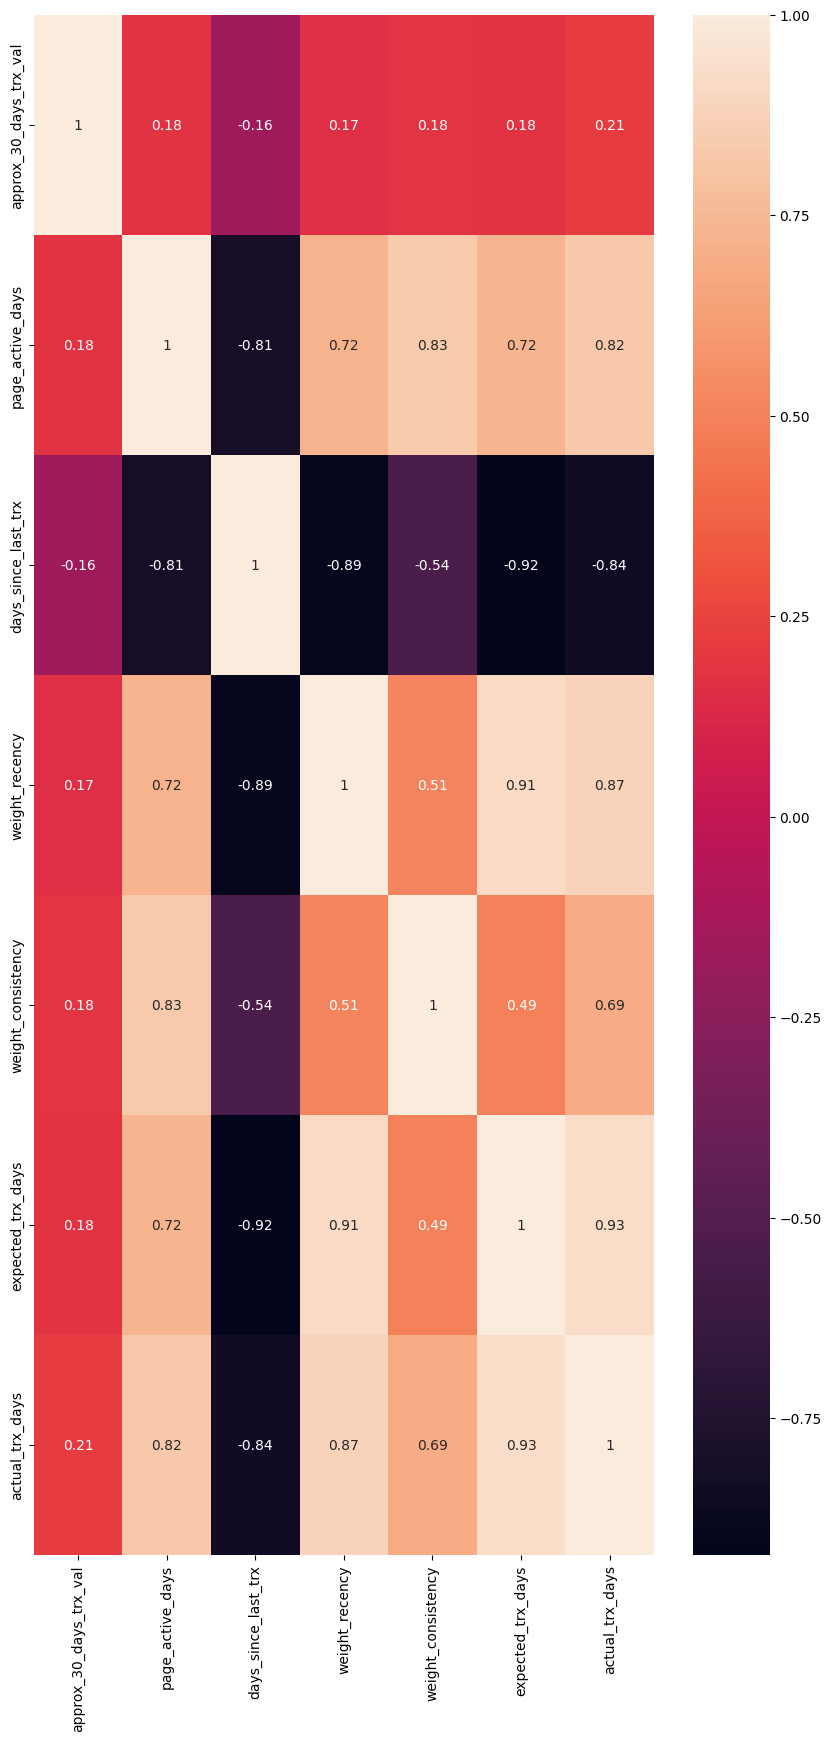

In [18]:
#Correlation analysis
correlations = selected_columns_corr.corr()

f, ax = plt.subplots(figsize = (10, 20))
sns.heatmap(correlations, annot = True)

In [19]:
without_performance_data = selected_columns[selected_columns['hurdle_rate_by_due_date_mean'].isnull()].reset_index(drop=True)
print(without_performance_data.shape)
with_performance_data = selected_columns[selected_columns['hurdle_rate_by_due_date_mean'].notnull()].reset_index(drop=True)
print(with_performance_data.shape)

(32976, 11)
(32457, 11)


In [20]:
with_performance_data[with_performance_data['hurdle_rate_by_end_rollover_date_mean'] > 1.02].shape

(9517, 11)

In [21]:
summaries = with_performance_data.copy()

In [22]:
# Features for clustering
# features = ["approx_30_days_trx_val", "page_active_days", "days_since_last_trx"]
features = ["approx_30_days_trx_val", "page_active_days", "days_since_last_trx", "weight_recency", "weight_consistency", "actual_trx_days"]

In [23]:
# # Split performance data into training and testing subsets
# train_with_performance_data, test_with_performance_data = train_test_split(with_performance_data, test_size=0.2, random_state=42)

In [24]:
# Scale the training data
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform scaler on training data
scaled_with_performance_data = scaler.fit_transform(with_performance_data[features])

In [25]:
with open("../models/clustering_scaler_model.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [26]:
# Apply PCA to the features and choose the number of components to retain
pca = PCA(n_components=2)  # You can adjust the number of components

# Apply PCA to the scaled training data
pca_scaled_with_performance_data = pca.fit_transform(scaled_with_performance_data)

In [27]:
with open("../models/clustering_pca_model.pkl", "wb") as f:
    pickle.dump(pca, f)

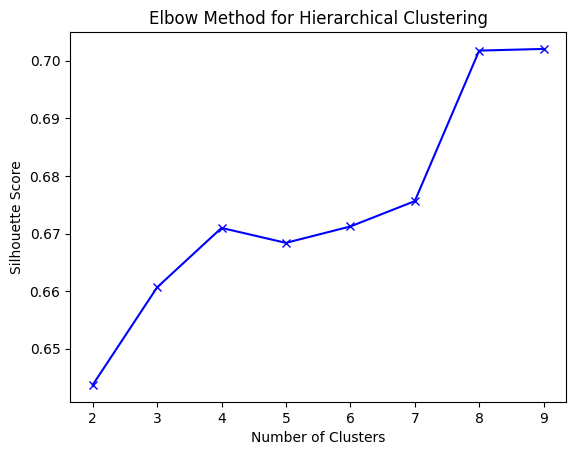

In [55]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
range_values = range(2, 10)  # Start from 2 clusters as 1 cluster doesn't make sense

for n_clusters in range_values:
    hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    hierarchical_clustering.fit(pca_scaled_with_performance_data)
    cluster_labels = hierarchical_clustering.labels_
    
    silhouette_scores.append(silhouette_score(pca_scaled_with_performance_data, cluster_labels))

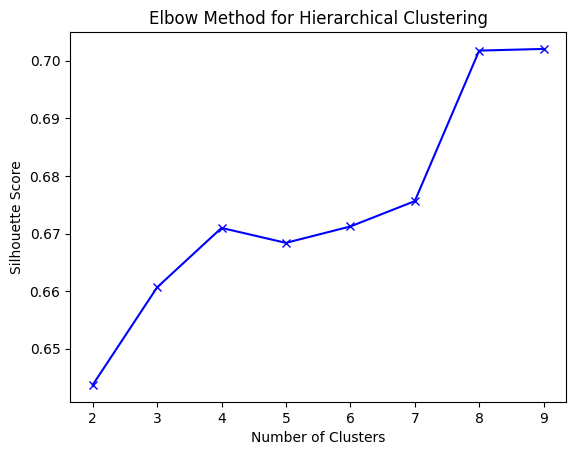

In [62]:
# Plot the silhouette scores
plt.plot(range_values, silhouette_scores, 'bx-')
plt.title('Elbow Method for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
# plt.ylim(0, 1)
plt.show()

In [98]:
# Fit hierarchical clustering to PCA-transformed training data
num_clusters = 8  # You can adjust the number of clusters
hierarchical = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
train_clusters = hierarchical.fit_predict(pca_scaled_with_performance_data)

# # Transform PCA-transformed testing data
# scaled_test_with_performance_data = scaler.transform(test_with_performance_data[features])
# pca_scaled_test_with_performance_data = pca.transform(scaled_test_with_performance_data)

# # Predict cluster labels for testing data using the trained hierarchical model
# test_clusters = hierarchical.fit_predict(pca_scaled_test_with_performance_data)

# Calculate silhouette score for clustering model on testing data
silhouette_avg = silhouette_score(pca_scaled_with_performance_data, train_clusters)
print(f"Silhouette Score on Testing Data: {silhouette_avg:.2f}")

Silhouette Score on Testing Data: 0.70


In [99]:
print("Number of unique train clusters:", len(np.unique(train_clusters)))

# print("Number of unique test clusters:", len(np.unique(test_clusters)))

Number of unique train clusters: 8


In [100]:
cluster_counts = np.bincount(train_clusters)

for cluster_label, count in enumerate(cluster_counts):
    print(f"Cluster {cluster_label}: {count} data points")

Cluster 0: 61 data points
Cluster 1: 2225 data points
Cluster 2: 210 data points
Cluster 3: 5916 data points
Cluster 4: 10219 data points
Cluster 5: 2492 data points
Cluster 6: 8132 data points
Cluster 7: 3202 data points


In [101]:
# cluster_counts = np.bincount(test_clusters)

# for cluster_label, count in enumerate(cluster_counts):
#     print(f"Cluster {cluster_label}: {count} data points")

In [102]:
num_clusters_found = hierarchical.n_clusters_
print(f"Number of clusters found: {num_clusters_found}")

Number of clusters found: 8


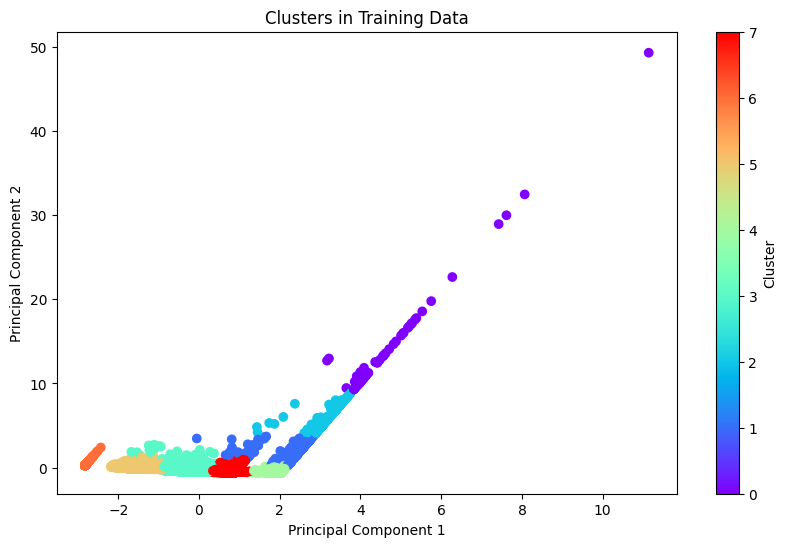

In [103]:
# Visualize training data clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_scaled_with_performance_data[:, 0], pca_scaled_with_performance_data[:, 1], c=train_clusters, cmap='rainbow')
plt.title("Clusters in Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

# # Visualize testing data clusters
# plt.figure(figsize=(10, 6))
# plt.scatter(pca_scaled_test_with_performance_data[:, 0], pca_scaled_test_with_performance_data[:, 1], c=test_clusters, cmap='rainbow')
# plt.title("Clusters in Testing Data")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.colorbar(label="Cluster")
# plt.show()

In [104]:
# Add the "clusters" column to both performance and without_performance data
with_performance_data["clusters"] = train_clusters

# # Scale the without performance data
# scaled_without_performance_data = scaler.transform(without_performance_data[features])

# # Apply PCA to scaled without performance data
# pca_scaled_without_performance_data = pca.transform(scaled_without_performance_data)

# # Predict clusters for PCA-transformed without performance data
# train_clusters_without_performance = hierarchical.fit_predict(pca_scaled_without_performance_data)

# without_performance_data["clusters"] = train_clusters_without_performance

In [105]:
with open("../models/hierarchical_model_1.pkl", "wb") as f:
    pickle.dump(hierarchical, f)

In [106]:
# without_performance_data["clusters"].value_counts()

In [107]:
with_performance_data["clusters"].value_counts()

clusters
4    10219
6     8132
3     5916
7     3202
5     2492
1     2225
2      210
0       61
Name: count, dtype: int64

In [108]:
# Calculate cluster means for the columns to predict
cluster_means_model_1 = with_performance_data.groupby("clusters")[["hurdle_rate_by_due_date_mean", "hurdle_rate_by_end_rollover_date_mean", "hurdle_rate_by_dpd30_mean"]].median()

cluster_means_model_1

,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
clusters,,,
0,0.902,1.031,1.033
1,0.884,1.006,1.031
2,0.917,1.031,1.032
3,0.684,0.825,0.915
4,0.803,0.952,1.026
5,0.684,0.825,0.923
6,0.684,0.785,0.882
7,0.724,0.879,0.962


In [109]:
# Identify the cluster with a large count
largest_main_cluster_index = np.argmax(np.bincount(train_clusters))

# Extract data points from the large cluster
largest_main_cluster_data = with_performance_data[train_clusters == largest_main_cluster_index]
pca_scaled_largest_main_cluster_data = pca_scaled_with_performance_data[largest_main_cluster_data.index]

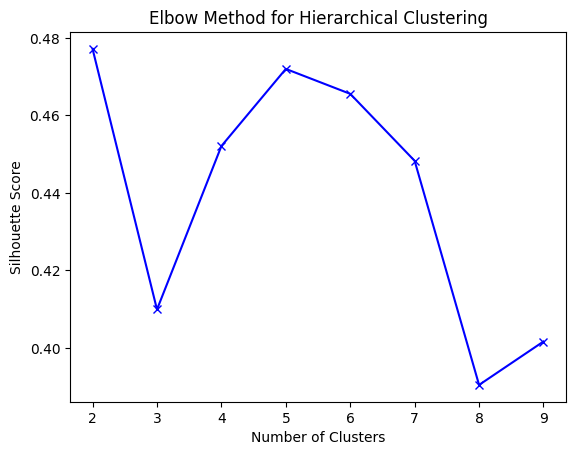

In [110]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
range_values = range(2, 10)  # Start from 2 clusters as 1 cluster doesn't make sense

for n_clusters in range_values:
    hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    hierarchical_clustering.fit(pca_scaled_largest_main_cluster_data)
    cluster_labels = hierarchical_clustering.labels_
    
    silhouette_scores.append(silhouette_score(pca_scaled_largest_main_cluster_data, cluster_labels))

# Plot the silhouette scores
plt.plot(range_values, silhouette_scores, 'bx-')
plt.title('Elbow Method for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [111]:
# Perform hierarchical subclustering on the largest main cluster
subcluster_num_clusters = 2
hierarchical_subcluster = AgglomerativeClustering(n_clusters=subcluster_num_clusters, metric='euclidean', linkage='ward')  # You can adjust the number of subclusters
subcluster_labels = hierarchical_subcluster.fit_predict(pca_scaled_largest_main_cluster_data)

# Calculate silhouette score for the subclusters
silhouette_avg_subclusters = silhouette_score(pca_scaled_largest_main_cluster_data, subcluster_labels)
print(f"Silhouette Score for Subclusters in Largest Main Cluster: {silhouette_avg_subclusters:.2f}")

# # Update subcluster labels to renumber them to fit within the existing range
# new_cluster_labels = subcluster_labels.copy()

# # Assign subcluster 0 as Cluster 1 and renumber the rest
# new_cluster_labels[subcluster_labels == 0] = largest_main_cluster_index  # Assign subcluster 0 as Cluster 1
# new_cluster_labels[subcluster_labels == 1] = max(train_clusters) + 1  # Assign subcluster 1 as the next available cluster label
# new_cluster_labels[subcluster_labels == 2] = max(train_clusters) + 2  # Assign subcluster 2 as the next available cluster label

# # Update main cluster labels with subcluster labels for the largest main cluster
# train_clusters[train_clusters == largest_main_cluster_index] = new_cluster_labels

Silhouette Score for Subclusters in Largest Main Cluster: 0.48


In [112]:
cluster_counts = np.bincount(subcluster_labels)

for cluster_label, count in enumerate(cluster_counts):
    print(f"Cluster {cluster_label}: {count} data points")

Cluster 0: 4163 data points
Cluster 1: 6056 data points


In [113]:
num_clusters_found = hierarchical_subcluster.n_clusters_
print(f"Number of clusters found: {num_clusters_found}")

Number of clusters found: 2


In [114]:
with_performance_data['clusters'] = with_performance_data['clusters'] + 1
with_performance_data['clusters_stage2'] = 0
with_performance_data.loc[train_clusters == largest_main_cluster_index, 'clusters_stage2'] = subcluster_labels + 1
with_performance_data['clusters_combined'] = with_performance_data['clusters'].astype('str') + '.' + with_performance_data['clusters_stage2'].astype('str')
with_performance_data['clusters_combined'].unique()

array(['5.2', '7.0', '6.0', '4.0', '5.1', '2.0', '8.0', '3.0', '1.0'],
      dtype=object)

In [115]:
# without_performance_data_max = without_performance_data[without_performance_data["clusters"] == train_clusters_without_performance]

# # Scale the without performance data
# scaled_without_performance_data_max = scaler.transform(without_performance_data_max[features])

# # Apply PCA to scaled without performance data
# pca_scaled_without_performance_data_max = pca.transform(scaled_without_performance_data_max)

# # Predict clusters for PCA-transformed without performance data
# without_performance_data_max["sub_clusters"] = hierarchical_subcluster.fit_predict(pca_scaled_without_performance_data_max)

In [116]:
with open("../models/hierarchical_model_2.pkl", "wb") as f:
    pickle.dump(hierarchical_subcluster, f)

In [117]:
largest_main_cluster_data['sub_clusters'] = subcluster_labels

# Calculate cluster means for the columns to predict
cluster_means_model_2 = largest_main_cluster_data.groupby("sub_clusters")[["hurdle_rate_by_due_date_mean", "hurdle_rate_by_end_rollover_date_mean", "hurdle_rate_by_dpd30_mean"]].median()

cluster_means_model_2

/tmp/ipykernel_6553/450517345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  largest_main_cluster_data['sub_clusters'] = subcluster_labels


,hurdle_rate_by_due_date_mean,hurdle_rate_by_end_rollover_date_mean,hurdle_rate_by_dpd30_mean
sub_clusters,,,
0,0.825,0.967,1.029
1,0.776,0.937,1.011


In [118]:
# without_performance_data_max['sub_clusters'].value_counts()

In [119]:
cluster_means_model_1 = cluster_means_model_1.rename(columns={'hurdle_rate_by_due_date_mean':'dd', 'hurdle_rate_by_end_rollover_date_mean':'erd', 'hurdle_rate_by_dpd30_mean':'dpd30'})

cluster_means_model_1

,dd,erd,dpd30
clusters,,,
0,0.902,1.031,1.033
1,0.884,1.006,1.031
2,0.917,1.031,1.032
3,0.684,0.825,0.915
4,0.803,0.952,1.026
5,0.684,0.825,0.923
6,0.684,0.785,0.882
7,0.724,0.879,0.962


In [184]:
# Create an empty DataFrame to store the transformed data
hurdle_rates_pred_model_1 = pd.DataFrame(columns=["cluster", "repayment_milestone", "hurdle_rate"])

# Iterate through each cluster and its associated data
for cluster, repayment_milestone in cluster_means_model_1.iterrows():
    cluster = str(cluster + 1.0)  # Adjust the cluster index to start from 1
    for repayment_milestone, hurdle_rate in repayment_milestone.items():
        hurdle_rates_pred_model_1 = pd.concat([hurdle_rates_pred_model_1,
            pd.Series({"cluster": cluster, "repayment_milestone": repayment_milestone, "hurdle_rate": hurdle_rate}).to_frame().T], ignore_index=True
        )
hurdle_rates_pred_model_1
# transformed_df.to_string(index=False)

,cluster,repayment_milestone,hurdle_rate
0,1.0,dd,0.902
1,1.0,erd,1.031
2,1.0,dpd30,1.033
3,2.0,dd,0.884
4,2.0,erd,1.006
5,2.0,dpd30,1.031
6,3.0,dd,0.917
7,3.0,erd,1.031
8,3.0,dpd30,1.032
9,4.0,dd,0.684


In [180]:
cluster_means_model_2 = cluster_means_model_2.rename(columns={'hurdle_rate_by_due_date_mean':'dd', 'hurdle_rate_by_end_rollover_date_mean':'erd', 'hurdle_rate_by_dpd30_mean':'dpd30'})

cluster_means_model_2

,dd,erd,dpd30
sub_clusters,,,
0,0.825,0.967,1.029
1,0.776,0.937,1.011


In [125]:
largest_main_cluster_index

4

In [187]:
# Create an empty DataFrame to store the transformed data
hurdle_rates_pred_model_2 = pd.DataFrame(columns=["cluster", "repayment_milestone", "hurdle_rate"])

# Iterate through each cluster and its associated data
for cluster, repayment_milestone in cluster_means_model_2.iterrows():
    if cluster == 0:
        cluster = str(largest_main_cluster_index + 1) + '.1'
    elif cluster == 1:
        cluster = str(largest_main_cluster_index + 1) + '.2'
    else:
        cluster = cluster + 1  # Adjust the cluster index to start from 1
    for repayment_milestone, hurdle_rate in repayment_milestone.items():
        hurdle_rates_pred_model_2 = pd.concat([hurdle_rates_pred_model_2,
            pd.Series({"cluster": cluster, "repayment_milestone": repayment_milestone, "hurdle_rate": hurdle_rate}).to_frame().T], ignore_index=True                                 
        )
        
hurdle_rates_pred_model_2

,cluster,repayment_milestone,hurdle_rate
0,5.1,dd,0.825
1,5.1,erd,0.967
2,5.1,dpd30,1.029
3,5.2,dd,0.776
4,5.2,erd,0.937
5,5.2,dpd30,1.011


In [188]:
hurdle_rates_pred = pd.concat([hurdle_rates_pred_model_1, hurdle_rates_pred_model_2])

hurdle_rates_pred

,cluster,repayment_milestone,hurdle_rate
0,1.0,dd,0.902
1,1.0,erd,1.031
2,1.0,dpd30,1.033
3,2.0,dd,0.884
4,2.0,erd,1.006
5,2.0,dpd30,1.031
6,3.0,dd,0.917
7,3.0,erd,1.031
8,3.0,dpd30,1.032
9,4.0,dd,0.684


In [189]:
hurdle_rates_pred[hurdle_rates_pred.repayment_milestone == 'erd']

,cluster,repayment_milestone,hurdle_rate
1,1.0,erd,1.031
4,2.0,erd,1.006
7,3.0,erd,1.031
10,4.0,erd,0.825
13,5.0,erd,0.952
16,6.0,erd,0.825
19,7.0,erd,0.785
22,8.0,erd,0.879
1,5.1,erd,0.967
4,5.2,erd,0.937


In [217]:
hurdle_rates_pred = hurdle_rates_pred[~(hurdle_rates_pred['cluster'] == str(largest_main_cluster_index + 1) + '.0')]

hurdle_rates_pred

,cluster,repayment_milestone,hurdle_rate
0,1.0,dd,0.902
1,1.0,erd,1.031
2,1.0,dpd30,1.033
3,2.0,dd,0.884
4,2.0,erd,1.006
5,2.0,dpd30,1.031
6,3.0,dd,0.917
7,3.0,erd,1.031
8,3.0,dpd30,1.032
9,4.0,dd,0.684


In [218]:
hurdle_rates_pred = hurdle_rates_pred.sort_values(by='cluster', ascending=True)

# hurdle_rates_pred['cluster'] = hurdle_rates_pred['cluster'].round(1)

hurdle_rates_pred

,cluster,repayment_milestone,hurdle_rate
0,1.0,dd,0.902
1,1.0,erd,1.031
2,1.0,dpd30,1.033
3,2.0,dd,0.884
4,2.0,erd,1.006
5,2.0,dpd30,1.031
6,3.0,dd,0.917
7,3.0,erd,1.031
8,3.0,dpd30,1.032
9,4.0,dd,0.684


In [219]:
hurdle_rates_pred.to_parquet('../models/hurdle_rates_pred_no_target.parquet')

In [220]:
# # Fill missing values using predicted cluster means
# # Predict the cluster labels for rows without performance data
# predicted_clusters = without_performance_data["clusters"]
# imputed_values = cluster_means.loc[predicted_clusters]
# without_performance_data[["hurdle_rate_by_due_date_mean", "hurdle_rate_by_end_rollover_date_mean", "hurdle_rate_by_dpd30_mean"]] = imputed_values.values

In [221]:
# without_performance_data

In [222]:
# without_performance_data['clusters'].value_counts()

In [223]:
with_performance_data['clusters'].value_counts()

clusters
5    10219
7     8132
4     5916
8     3202
6     2492
2     2225
3      210
1       61
Name: count, dtype: int64

In [224]:
with_performance_data['clusters_combined'].value_counts()

clusters_combined
7.0    8132
5.2    6056
4.0    5916
5.1    4163
8.0    3202
6.0    2492
2.0    2225
3.0     210
1.0      61
Name: count, dtype: int64

In [225]:
# # Visualize clusters in without_performance_data
# plt.figure(figsize=(10, 6))
# plt.scatter(pca_scaled_without_performance_data[:, 0], pca_scaled_without_performance_data[:, 1], c=without_performance_data["clusters"], cmap='rainbow')
# plt.title("Clusters in Data without Performance")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.colorbar(label="Cluster")
# plt.show()

In [226]:
# # Combine PCA-transformed data from both subsets
# all_pca_data = np.vstack((pca_scaled_train_with_performance_data, pca_scaled_test_with_performance_data, pca_scaled_without_performance_data))

# # Combine cluster labels from both subsets
# all_clusters = np.concatenate((train_clusters, test_clusters, without_performance_data["clusters"]))

# # Visualize clusters in the whole dataset
# plt.figure(figsize=(10, 6))
# plt.scatter(all_pca_data[:, 0], all_pca_data[:, 1], c=all_clusters, cmap='rainbow')
# plt.title("Clusters in Whole Dataset")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.colorbar(label="Cluster")
# plt.show()

In [227]:
# # Concatenate known and imputed data
# imputed_df = pd.concat([train_with_performance_data, without_performance_data])

# imputed_df.shape

In [228]:
# imputed_df['clusters'].value_counts()

In [229]:
# imputed_df.head(3)

In [230]:
# imputed_df.info()

In [231]:
# with open("../models/kmeans_model.pkl", "wb") as f:
#     pickle.dump(kmeans, f)

In [232]:
# with open("../models/scaler_model.pkl", "wb") as f:
#     pickle.dump(scaler, f)

In [233]:
# # Create a sample dataframe
# data = {'cluster': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5], 'repayment_milestone': ['dd', 'erd', 'dpd30', 'dd', 'erd', 'dpd30', 'dd', 'erd', 'dpd30', 'dd', 'erd', 'dpd30', 'dd', 'erd', 'dpd30'], 'hurdle_rate': [round(c1_ratio_by_dd, 3), round(c1_ratio_by_erd, 3), round(c1_ratio_by_dpd30, 3), round(c2_ratio_by_dd, 3), round(c2_ratio_by_erd, 3), round(c2_ratio_by_dpd30, 3), round(c3_ratio_by_dd, 3), round(c3_ratio_by_erd, 3), round(c3_ratio_by_dpd30, 3), round(c4_ratio_by_dd, 3), round(c4_ratio_by_erd, 3), round(c4_ratio_by_dpd30, 3), round(c5_ratio_by_dd, 3), round(c5_ratio_by_erd, 3), round(c5_ratio_by_dpd30, 3)]}
# hurdle_rates_pred = pd.DataFrame(data)

In [234]:
# hurdle_rates_pred

In [235]:
# hurdle_rates_pred.to_parquet('../models/hurdle_rates_pred.parquet')

In [236]:
# df = pd.read_parquet('../models/hurdle_rates_pred.parquet')

# df

### Classifier

In [237]:
label_encoder = LabelEncoder()
with_performance_data['target'] = label_encoder.fit_transform(with_performance_data['clusters_combined'])
sorted(with_performance_data['target'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [238]:
sorted(with_performance_data['clusters_combined'].unique())

['1.0', '2.0', '3.0', '4.0', '5.1', '5.2', '6.0', '7.0', '8.0']

In [240]:
hurdle_rates_pred['target'] = label_encoder.transform(hurdle_rates_pred['cluster'])
hurdle_rates_pred

,cluster,repayment_milestone,hurdle_rate,target
0,1.0,dd,0.902,0
1,1.0,erd,1.031,0
2,1.0,dpd30,1.033,0
3,2.0,dd,0.884,1
4,2.0,erd,1.006,1
5,2.0,dpd30,1.031,1
6,3.0,dd,0.917,2
7,3.0,erd,1.031,2
8,3.0,dpd30,1.032,2
9,4.0,dd,0.684,3


In [252]:
hurdle_rates_pred.to_parquet('../models/hurdle_rates_pred.parquet')

In [242]:
X = with_performance_data[features]
y = with_performance_data['target']

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(22719, 6)
(9738, 6)


In [244]:
clf_scaler = StandardScaler()
X_train_scale = clf_scaler.fit_transform(X_train)
X_test_scale = clf_scaler.transform(X_test)

In [251]:
with open("../models/clf_scaler_model.pkl", "wb") as f:
    pickle.dump(clf_scaler, f)

In [245]:
clf = RandomForestClassifier()
clf.fit(X_train_scale, y_train)

RandomForestClassifier()

In [249]:
with open("../models/decision_tree_model.pkl", "wb") as f:
    pickle.dump(clf, f)

In [246]:
y_pred = clf.predict(X_test_scale)
y_pred_probs = clf.predict(X_test_scale)

<Axes: >

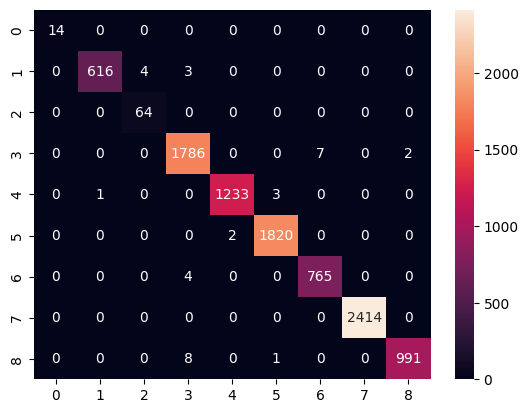

In [247]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.0f')

In [248]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.99      0.99       623
           2       0.94      1.00      0.97        64
           3       0.99      0.99      0.99      1795
           4       1.00      1.00      1.00      1237
           5       1.00      1.00      1.00      1822
           6       0.99      0.99      0.99       769
           7       1.00      1.00      1.00      2414
           8       1.00      0.99      0.99      1000

    accuracy                           1.00      9738
   macro avg       0.99      1.00      0.99      9738
weighted avg       1.00      1.00      1.00      9738



In [167]:
# # trans = TSNE(n_components=2, metric='euclidean', random_state=42)
# # trans = PCA(n_components=2, random_state=42)
# trans = UMAP(n_components=2, n_neighbors=1000, random_state=42, metric='cosine').fit(X_train_scale)

# fig, ax = plt.subplots(figsize=(12,8))
# ax.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=5, c=y_train, cmap='Spectral')
# ax.set_title('Embedding of the training set', fontsize=24)

# X_test_trans = trans.transform(X_test_scale)

# fig, ax = plt.subplots(figsize=(12,8))
# ax.scatter(X_test_trans[:, 0], X_test_trans[:, 1], s=5, c=y_pred, cmap='Spectral')
# ax.set_title('Embedding of the testing set', fontsize=24)